# XGBoost

XGBoost (Extreme Gradient Boosting) belongs to a family of boosting algorithms and uses the gradient boosting (GBM) framework at its core. 

Reference\
https://www.datacamp.com/community/tutorials/xgboost-in-python

## Boosting
Boosting is a sequential technique which works on the principle of an **ensemble**. It combines a set of **weak learners** and delivers improved prediction accuracy.

At any instant t, the model outcomes are weighed based on the outcomes of previous instant t-1. The outcomes predicted correctly are given a lower weight and **the ones miss-classified are weighted higher**.
![](https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1528107577/output_1_0_ilvuyr.png)
The second classifier _Box2_ gives more weight to the three + misclassified points (the bigger size of +) and creates a vertical line at D2. The third classifier _Box3_ gives more weight to the three - misclassified points and creates a horizontal line at D3. _Box4_ is the weighted combination of the weak classifiers (_Box 1,2_ and _3_).

## Tree ensembles
The tree ensemble model is a set of classification and regression trees (CART). Trees are grown one after another and attempt to reduce the misclassification rate made in subsequent iterations.

If you plan to use XGBoost on a dataset which has **categorical** features you may want to consider applying some **encoding** (like one-hot encoding) to such features before training the model. Also, if you have some missing values such as `NA` in the dataset you may or may not do a separate treatment for them, because **XGBoost is capable of handling missing values internally**. You can check out this [link](https://github.com/dmlc/xgboost/issues/21) if you wish to know more on this.

### Data Preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics

%matplotlib inline

In [3]:
data = pd.read_csv('TrainOnMe.csv')

unique_y = ['Atsuto','Bob','Jörg']
data = data[data['y'].isin(unique_y)]
unique_x5 = ['True', 'False']
data = data[data['x5'].isin(unique_x5)]
unique_x6 = ['F', 'A', 'Fx', 'C', 'E', 'B', 'D']
data = data[data['x6'].isin(unique_x6)]
data[['x1','x2','x3','x4','x7','x8','x9','x10']] = data[['x1','x2','x3','x4','x7','x8','x9','x10']].apply(pd.to_numeric)

print(f"Shape of the data: {data.shape}\n")
print("y unique and count: ")
print(data.y.value_counts())
print('\n')
print("x5 unique and count: ")
print(data.x5.value_counts())
print('\n')
print("x6 unique and count: ")
print(data.x6.value_counts())
data.head()

shape of the data: (997, 12)

y unique and count: 
Bob       517
Atsuto    296
Jörg      184
Name: y, dtype: int64


x5 unique and count: 
False    685
True     312
Name: x5, dtype: int64


x6 unique and count: 
F     617
A     228
Fx     35
C      33
E      29
B      28
D      27
Name: x6, dtype: int64


,id,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
0,0,Bob,-0.78103,-0.63375,-0.03665,0.27517,False,F,-1.85755,0.22668,-2.35130,1.42092
1,1,Bob,0.42649,-0.50019,0.00696,0.11817,False,F,-1.73761,-1.61015,-5.12219,1.87723
2,2,Atsuto,1.86817,-0.45565,0.07658,0.09662,False,F,1.02798,-0.92326,-1.67111,2.07828
3,3,Atsuto,-1.80073,0.08535,-0.02467,0.14032,False,F,2.02793,-0.46318,2.41329,-0.62963
4,4,Bob,1.56943,-1.25860,-0.02092,0.22267,False,F,-0.43304,-1.99881,-1.58241,2.28423


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 995 entries, 0 to 1000
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      995 non-null    object 
 1   y       995 non-null    object 
 2   x1      995 non-null    float64
 3   x2      995 non-null    float64
 4   x3      995 non-null    float64
 5   x4      995 non-null    float64
 6   x5      995 non-null    object 
 7   x6      995 non-null    object 
 8   x7      995 non-null    float64
 9   x8      995 non-null    float64
 10  x9      995 non-null    float64
 11  x10     994 non-null    float64
dtypes: float64(8), object(4)
memory usage: 101.1+ KB


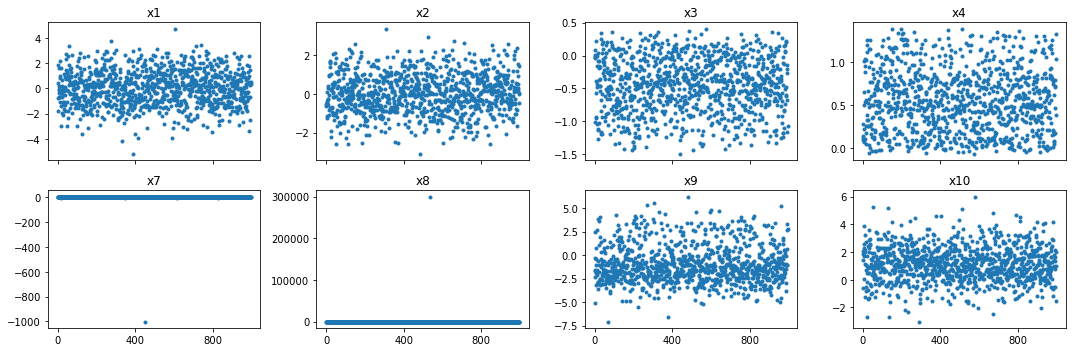

In [13]:
fig,ax = plt.subplots(2,4,figsize=(15,5),sharex=True)

continuous_fealtures = ['x1','x2','x3','x4','x7','x8','x9','x10']

for axi,fea in zip(ax.flat,continuous_fealtures):
    pts = (data.loc[:,[fea]]).to_numpy().flatten()
    axi.plot(pts,'.')
    axi.xaxis.set_major_locator(plt.MaxNLocator(3))
    axi.set_title(fea)

fig.tight_layout()
plt.show()

In [14]:
# remove outliers
threshold = 100
data = data.drop(data[(data.x7 < -threshold) | (data.x7 > threshold)].index)
data = data.drop(data[(data.x8 < -threshold) | (data.x8 > threshold)].index)

In [17]:
# separate labels and features
y, X = data.iloc[:,1], data.iloc[:,2:]

# map y from object to int
y_dict = {'Atsuto': 0, 'Bob': 1, 'Jörg':2}
y = y.replace(y_dict)

# one-hot encoding for categorical features
X = pd.get_dummies(X)

In [18]:
y.head()

0    1
1    1
2    0
3    0
4    1
Name: y, dtype: int64

In [23]:
print(f"Shape of the data: {X.shape}")
print(f"Is there null value in entries: {X.isnull().values.any()}")
X.head()

Shape of the data: (995, 17)
Is there null value in entries: True


,x1,x2,x3,x4,x7,x8,x9,x10,x5_False,x5_True,x6_A,x6_B,x6_C,x6_D,x6_E,x6_F,x6_Fx
0,-0.78103,-0.63375,-0.03665,0.27517,-1.85755,0.22668,-2.35130,1.42092,1,0,0,0,0,0,0,1,0
1,0.42649,-0.50019,0.00696,0.11817,-1.73761,-1.61015,-5.12219,1.87723,1,0,0,0,0,0,0,1,0
2,1.86817,-0.45565,0.07658,0.09662,1.02798,-0.92326,-1.67111,2.07828,1,0,0,0,0,0,0,1,0
3,-1.80073,0.08535,-0.02467,0.14032,2.02793,-0.46318,2.41329,-0.62963,1,0,0,0,0,0,0,1,0
4,1.56943,-1.25860,-0.02092,0.22267,-0.43304,-1.99881,-1.58241,2.28423,1,0,0,0,0,0,0,1,0


## XGBoost's hyperparameters
- `learning_rate` step size shrinkage used to prevent overfitting. Range is [0,1].
- `max_depth` determines how deeply each tree is allowed to grow during any boosting round.
- `subsample` percentage of samples used per tree. Low value can lead to underfitting.
- `colsample_bytree` percentage of features used per tree. High value can lead to overfitting.
- `n_estimators` number of trees you want to build.
- `objective` determines the loss function to be used like `reg:linear` for regression problems, `reg:logistic` for classification problems with only decision, `binary:logistic` for classification problems with probability.

In [27]:
# convert the data into an optimized data structure
# that XGBoost supports
data_dmatrix = xgb.DMatrix(data=X,label=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [28]:
# XGBClassifier() for classification
xg_clf = xgb.XGBClassifier()
xg_clf.fit(X_train,y_train)
preds = xg_clf.predict(X_test)

In [29]:
print("Accuracy:",metrics.accuracy_score(y_test, preds))

Accuracy: 0.8944723618090452


## K-fold Cross Validation
- `num_boost_round` denotes the number of trees you build (analogous to n_estimators).
- `metrics` tells the evaluation metrics to be watched during CV.
- `as_pandas` returns the results in a pandas DataFrame.
- `early_stopping_rounds` finishes training of the model early if the hold-out metric does not improve for a given number of rounds.
- `seed` for reproducibility of results.

Reference \
[Hyperparameter tuning in XGBoost](https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f)

In [ ]:
test_data = pd.read_csv('EvaluateOnMe.csv')
test_data.head()